In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [3]:
env = gym.make('FrozenLake-v1', is_slippery=True)

q =  np.zeros((env.observation_space.n, env.action_space.n))

learning_rate_a = 0.8
discount_factor_g = 0.9

state, info = env.reset()
terminated = False
truncated = False

while (not terminated and not truncated):
    action = env.action_space.sample()
    new_state, reward, terminated, truncated, _ = env.step(action)
    ## current state x action on q table
    ## on first run 0 + 0.8 * (reward + 0.9 * 0 - 0)
    q[state, action] = q[state, action] + \
                        learning_rate_a * \
                            (reward + discount_factor_g * \
                                 np.max(q[new_state,:]) - q[state,action]
                            )
                             
    state = new_state

env.close()
q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

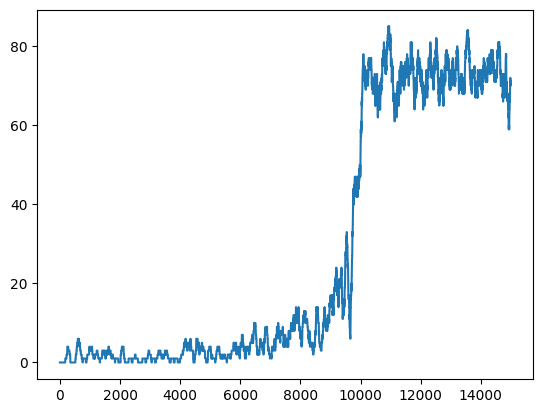

In [4]:

episodes = 15000
env = gym.make('FrozenLake-v1', is_slippery=True)

q =  np.zeros((env.observation_space.n, env.action_space.n))

learning_rate_a = 0.9
discount_factor_g = 0.9

epsilon = 1  # 1 = 100% random actions
epsilon_decay_rate = 0.0001 # epsilon decay rate
rng = np.random.default_rng()

rewards_per_episode = np.zeros(episodes)
for i in range(episodes):
    state, info = env.reset()
    terminated = False
    truncated = False

    
    while not terminated and not truncated:
        if rng.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q[state,:])
        new_state, reward, terminated, truncated, _ = env.step(action)
        ## current state x action on q table
        ## on first run 0 + 0.8 * (reward + 0.9 * 0 - 0)
        q[state, action] = q[state, action] + \
                            learning_rate_a * \
                                (reward + discount_factor_g * \
                                     np.max(q[new_state,:]) - q[state,action]
                                )
                                 
        state = new_state
    epsilon = max(epsilon - epsilon_decay_rate, 0)
    if epsilon==0:
        learning_rate_a=0.0001
    if reward == 1:
        rewards_per_episode[i] = 1
    
env.close()
sum_rewards = np.zeros(episodes)
for t in range(episodes):
    sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):t+1])

plt.plot(sum_rewards)

In [5]:
## now we are going to use deep q learning
import torch
from torch import nn
import torch.nn.functional as F
from collections import deque
import random

class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.out = nn.Linear(h1_nodes, out_actions)

    def forward(self, x):
        return self.out(F.relu(self.fc1(x)))

class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

        

In [6]:
class FrozenLakeDQL():
    learning_raet_a = 0.001
    discount_factor_g = 0.9
    network_sync_rate = 10
    replay_memory_size = 1000
    mini_batch_size = 32

    loss_fn = nn.MSELoss()
    optimizer = None

    ACTIONS = ['L', 'D', 'R', 'U']

    def state_to_dqn_input(self, state, num_states)-> torch.Tensor: ## one hot encoding
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor

    
    def train(self, episodes):
        env = gym.make('FrozenLake-v1', is_slippery=True)
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        epsilon = 1
        memory = ReplayMemory(self.replay_memory_size)

        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)

        target_dqn.load_state_dict(policy_dqn.state_dict())

        self.print_dqn(policy_dqn)

        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_raet_a)

        rewards_per_episode = np.zeros(episodes)

        epsilon_history = []

        step_count = 0

        for i in range(episodes):
            state, _ = env.reset()
            terminated = False
            truncated = False
        
            
            while not terminated and not truncated:
                if rng.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()
                new_state, reward, terminated, truncated, _ = env.step(action)

                memory.append((state, action, new_state, reward, terminated))
                                         
                state = new_state
                step_count+=1

            #epsilon = max(epsilon - epsilon_decay_rate, 0)
            #if epsilon==0:
            #    learning_rate_a=0.0001
            if reward == 1:
                rewards_per_episode[i] = 1

            if len(memory) >self.mini_batch_size and np.sum(rewards_per_episode)>0:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0
            
        env.close()

        torch.save(policy_dqn.state_dict(), "frozen_lake_dqn.pt")
        plt.figure(1)
        sum_rewards = np.zeros(episodes)
        for t in range(episodes):
            sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):t+1])

        plt.subplot(121)
        plt.plot(sum_rewards)

        plt.subplot(122)
        plt.plot(epsilon_history)

    def optimize(self, mini_batch, policy_dqn, target_dqn):
        num_states = policy_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )
            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            target_q = target_dqn(self.state_to_dqn_input(state, num_states))
            target_q[action] = target

            target_q_list.append(target_q)

        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def test(self, episodes):
        env = gym.make('FrozenLake-v1', is_slippery=True)
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        policy_dqn = DQN(in_states=num_states, h1_nodes=num_states, out_actions=num_actions)
        policy_dqn.load_state_dict(torch.load("frozen_lake_dqn.pt"))
        policy_dqn.eval()

        self.print_dqn(policy_dqn)

        for i in range(episodes):
            state, _ = env.reset()
            terminated = False
            truncated = False
        
            
            while not terminated and not truncated:
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()
                new_state, reward, terminated, truncated, _ = env.step(action)
        env.close()

    def print_dqn(self, dqn):
        num_states = dqn.fc1.in_features

        for s in range(num_states):
            q_values = ''
    

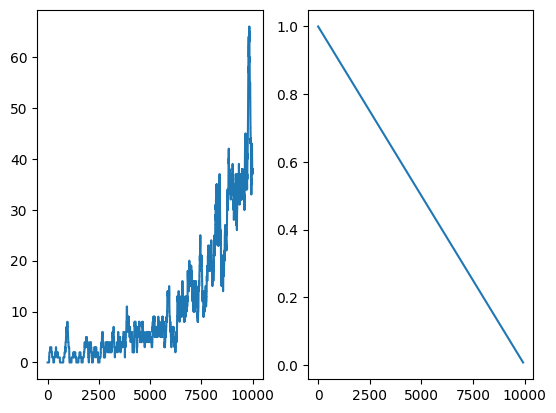

In [8]:
frozen_lake = FrozenLakeDQL()
frozen_lake.train(10000)
#frozen_lake.test(4)